# Forward and Backward pass

The idea of this notebook is to understand the `forward` and `backward` pass algorithms and implement them from scratch.

Once the algorithms are understood, we use `PyTorch` which has those algorithms already implemented.

In [1]:
import torch
import math

# Get the MNIST dataset
import gzip, pickle
import urllib.request
from pathlib import Path

MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"
data_path = Path("../data")
data_path.mkdir(parents=True, exist_ok=True)
data_gz = data_path/"mnist.pkl.gz"

# Get the data
if not data_gz:
    urllib.request.urlretrieve(MNIST_URL, data_path/"mnist.pkl.gz")
    
# Destructuring
with gzip.open(data_gz, mode='rb') as unzip_data:
    obj = pickle.load(unzip_data, encoding="latin-1")
    ((x_train, y_train), (x_valid, y_valid), _) = obj

# To tensors
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

## Forward pass

The `forward pass` computes the predictions of a model using matrix multiplication.

Let's assume we're going to create a 2-layer network.

To define the forward pass, we need to create the linear layers as `y = x @ w + b`

In [2]:
def lin(x, w, b):
    """ Linear layer"""
    return x @ w + b

### Initialization definition

To understand the `initialization` we assume the following dimentsions:

In [3]:
x = torch.randn(200, 100)
y = torch.rand(200)
w1 = torch.randn(100, 50)
b1 = torch.zeros(50)

According to einsum: `ij,jk -> ik`

In [4]:
l1 = lin(x, w1, b1)
l1.shape

torch.Size([200, 50])

`l1` is a batch of hidden state.

Based on the output from layer-1, I know the dimensions of layer-2.

In [5]:
w2 = torch.randn(50, 1)
b2 = torch.zeros(1)

In [6]:
l1.mean(), l1.std()

(tensor(-0.0739), tensor(10.1855))

Notice how we're using a `normal` distribution to init the weights.

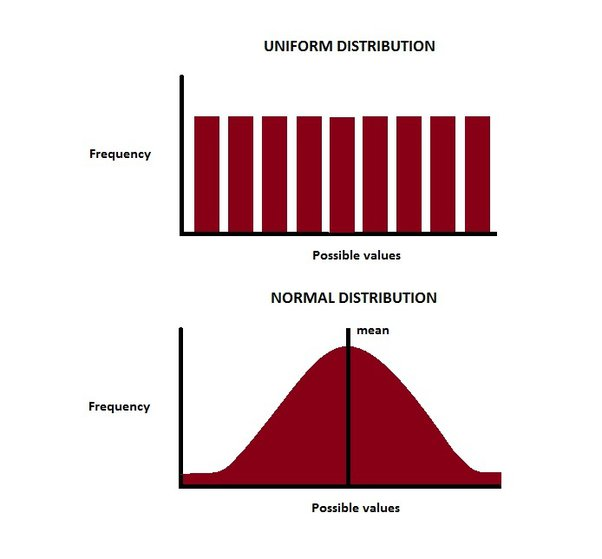

If we keep running dot products the `std()` will reach out of bound numbers.

In [7]:
for i in range(50):
    x = x @ torch.randn(100, 100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

So, we need an initialization.

Originally proposed initialization was the ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

Glorot et. al: $1/\sqrt{n_{in}}$

Our input is 100 so the initialization will be 0.1

In [8]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ (torch.randn(100, 100) * math.sqrt(1/100))

In [9]:
x.mean(), x.std()

(tensor(-0.0024), tensor(0.7354))

This is nice, because `std` is being kept on low numbers.

In [10]:
def glorot_init(nof_inputs):
    """
    Glorot initializer.
    """
    return math.sqrt(1/nof_inputs)

Let's redefine our inputs based on the `Glorot` initializer.

In [11]:
x = torch.randn(200, 100)
y = torch.randn(200)

w1 = torch.randn(100, 50) * glorot_init(100)
b1 = torch.zeros(50)

So, we can calculate `l1`:

In [12]:
l1 = lin(x, w1, b1)
l1.shape, l1.mean(), l1.std()

(torch.Size([200, 50]), tensor(-0.0255), tensor(0.9763))

We pass `l1` through ReLU:

In [13]:
def relu(l):
    return l.clamp_min(0.)

In [14]:
l2 = relu(l1)
l2.shape, l2.mean(), l2.std()

(torch.Size([200, 50]), tensor(0.3766), tensor(0.5601))

The mean is again not close to 0, so the `glorot_init()` is not sufficient.

In [15]:
for i in range(50):
    x = relu(x @ torch.randn(100, 100) * glorot_init(100))
x[0:5,0:5]

tensor([[0.0000e+00, 2.2985e-08, 0.0000e+00, 1.9322e-08, 0.0000e+00],
        [0.0000e+00, 2.2496e-08, 0.0000e+00, 1.9254e-08, 0.0000e+00],
        [0.0000e+00, 2.2556e-08, 0.0000e+00, 1.8519e-08, 0.0000e+00],
        [0.0000e+00, 3.8114e-08, 0.0000e+00, 2.9319e-08, 0.0000e+00],
        [0.0000e+00, 2.5550e-08, 0.0000e+00, 2.2522e-08, 0.0000e+00]])

An improved initialization: ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852)

Kaiming He et al.: $\sqrt{2 / n_{in}}$

In [16]:
def kaiming_init(n_input):
    """ Kaiming He et al. initialization """
    return math.sqrt(2/n_input)

In [17]:
x = torch.randn(200, 100)
y = torch.randn(200)

w1 = torch.randn(100, 50) * kaiming_init(100)
b1 = torch.zeros(50)

w2 = torch.randn(50, 1) * kaiming_init(50)
b2 = torch.zeros(1)

In [18]:
l1 = lin(x, w1, b1)
l2 = relu(l1)
l3 = lin(l2, w2, b2)

l3.mean(), l3.std()

(tensor(-0.1462), tensor(1.2913))

---

Now that the initialization has been properly defined, we can continue with the **`forward pass`** and create the initial version of the model:

In [19]:
def model(x):
    """ Forward pass implemenetation """
    l1 = lin(x, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3 # activations

In [20]:
out = model(x)
out.shape, y.shape

(torch.Size([200, 1]), torch.Size([200]))

DImensions don't match, let's fix that:

In [21]:
out.squeeze().shape, y.shape

(torch.Size([200]), torch.Size([200]))

### Use real data

In [22]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50
n,m,c

(50000, 784, tensor(10))

In [23]:
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)
b2 = torch.zeros(1)

The sizes of `w2` and `b2` are simplified.

In [24]:
res = model(x_valid)
res.shape

torch.Size([10000, 1])

### Define Loss function - simplified

In order to implement a basic `SGD` we need a `loss` function upon which we can improve the parameters.

This loss function is not ideal for the MNIST dataset because of how it works. MSE returns the distance between 2 elements. So, in this case, it will just tell you how far the predicted number is from the actual. Ideally, we would use cross-entropy loss.

We define the MSE loss function bellow (just like Euclidean distance):

In [25]:
def mse_func(predictions, targets):
    """ Mean Squared Error function """
    t = (predictions - targets).pow(2).mean()
    return t

However:

In [26]:
res.shape, y_valid.shape

(torch.Size([10000, 1]), torch.Size([10000]))

In [27]:
(res-y_valid).shape # Wrong dimensions

torch.Size([10000, 10000])

Because of `broadcasting` rules, we will get wrong results.

In [28]:
mse_func(res, y_valid)

tensor(1442.0046)

We need to remove the extra dimension in our predictions.

In [29]:
# 1st way
res[:,0].shape

torch.Size([10000])

In [30]:
# 2nd way
res.squeeze().shape # Removes unit dimensions

torch.Size([10000])

In [31]:
# 3rd way
torch.einsum("ij,i->i", res, y_valid).shape

torch.Size([10000])

Now that we know how to get the loss, we re-implement it.

In [32]:
def mse_func(predictions, targets):
    """ Mean Squared Error function """
    t = (predictions.squeeze() - targets).pow(2).mean()
    return t

... and re-run the model to get the predictions and loss:

In [33]:
y_train, y_valid = y_train.float(), y_valid.float()
preds = model(x_train)
preds.shape

torch.Size([50000, 1])

In [34]:
mse_func(preds, y_train)

tensor(1423.3717)

In [35]:
# Now we can define our mse function
mse = mse_func

### Sympy

is a useful library for working with calculus. In our case it's useful for calculating derivatives.

In [36]:
from sympy import symbols, diff

In [37]:
sx, sy = symbols("sx, sy") # Define the symbols
diff(sx**2, sx) # Do the computation

2*sx

In [38]:
diff(sx*2, sx)

2

## Backward pass

To make `SGD` work we need to be able to update the weights. To update the weights, we need to calculate the gradient, which measures for each weight, how changing that weight would change the loss.

However, calculating the gradient of the `Loss` is a complex function because

```
loss = mse(out,y) = mse(lin(l2, w2, b2), y) =
                    mse(lin(Relu(l1), w2, b2), y) =
                    mse(lin((Relu(lin(x, w1, b1)), w2, b2), y)
```

With that in regard, we see that to get the gradient of the `loss` with respect to its parameters, such as b1, we need to recursively calculate the gradient of the previous laters with respect to the same parameter. This recursive (backward) calculation of the gradients is called `Backpropagation/Backward pass`.

To find the gradients of the previous outputs recursively, we use the chain rule: `Chain Rule`

$$(g \circ f)'(x) = g'(f(x)) f'(x)$$

So, for our example:

$$\frac{\text{d} loss}{\text{d} b_{2}} = \frac{\text{d} loss}{\text{d} out} \times \frac{\text{d} out}{\text{d} b_{2}} = \frac{\text{d}}{\text{d} out} mse(out, y) \times \frac{\text{d}}{\text{d} b_{2}} lin(l_{2}, w_{2}, b_{2})$$


If we define the gradient of the loss with respect to the ouput (p) with `sympy`:

In [39]:
p, t, n = symbols("p, t, n")
sym_mse = ((p - t)**2/n)
diff(sym_mse, p)

(2*p - 2*t)/n

So, we can define the forward and backward passes as a whole:

In [40]:
def mse_grad(inp, targ):
    # grad of loss with respect to output of previous layer - l3
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [41]:
def relu_grad(inp, out):
    # grad of relu with respect to input activations
    inp.g = (inp>0).float() * out.g

In [42]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [43]:
def forward_and_backward_pass(inp, y):
    """
    Computes the forward pass - activations and loss.
    Computes the backward pass - loss and layer gradients.
    """
    
    # Forward pass
    l1 = lin(inp, w1, b1)
    l2 = relu(l1)
    l3 = out = lin(l2, w2, b2)
    diff = out[:,0] - targ
    loss = diff.pow(2).mean()
    
    # Backward pass
    
    # Copy pasted from here onwards - should re-write the function code here
    out.g = 2.*diff[:,None] / inp.shape[0]
    lin_grad(l2, out, w2, b2)
    l1.g = (l1>0).float() * l2.g
    lin_grad(inp, l1, w1, b1)

So, a whole forward and backward pass would look like:

In [44]:
# Or we can rewrite it

#import pdb

def forward_and_backward_pass(inp, targ):
    
    # Forward pass
    l1 = lin(inp, w1, b1) # inp @ w1 + b1
    l2 = relu(l1)
    l3 = out = lin(l2, w2, b2) # l2 @ w2 + b2
    loss = mse(out, targ)
    
    #pdb.set_trace()
    
    # Backward pass
    mse_grad(l3, targ)
    #pdb.set_trace()
    
    lin_grad(l2, l3, w2, b2)
    #pdb.set_trace()
    
    relu_grad(l1, l2)
    #pdb.set_trace()
    
    lin_grad(inp, l1, w1, b1) 
    
    print(f"loss: {loss}")

In [45]:
forward_and_backward_pass(x_train, y_train)

loss: 1423.3717041015625


---

### TODO

I can't seem to be able to understand the backpropagation.
I need to read some more on it.
For now I am going to take things as they are.

- https://www.3blue1brown.com/lessons/backpropagation
- https://colah.github.io/posts/2015-08-Backprop/
- https://towardsdatascience.com/part-2-gradient-descent-and-backpropagation-bf90932c066a
- https://forbo7.github.io/forblog/posts/18_backprop_from_scratch.html
- https://medium.com/@jorgesleonel/backpropagation-cc81e9c772fd

Perhaps a good example to understand `backpropagation`: [micrograd](https://github.com/karpathy/micrograd/tree/master)

I have almost bluntly pasted the backpropagation from the notebook and also in the grad functions bellow.


---

### Just confirm the derivatives by using PyTorch

In [46]:
# Save for testing against later
def get_grad(x):
    return x.g.clone()
chks = w1,w2,b1,b2,x_train
grads = w1g,w2g,b1g,b2g,ig = tuple(map(get_grad, chks))

In [47]:
def mkgrad(x):
    return x.clone().requires_grad_(True)

ptgrads = w12,w22,b12,b22,xt2 = tuple(map(mkgrad, chks))

In [48]:
def forward(inp, targ):
    l1 = lin(inp, w12, b12)
    l2 = relu(l1)
    out = lin(l2, w22, b22)
    return mse(out, targ)

In [49]:
loss = forward(xt2, y_train)
loss.backward()

In [50]:
from fastbook import test_close

In [51]:
for a,b in zip(grads, ptgrads): test_close(a, b.grad, eps=0.01)
# If you have no output then the results are close to the ones from PyTorch

# Implement `Model` class

We have implemented the `forward` and `backward` pass as individual functions. Now we can implement the `Model` class of our `Neural Network` which has the aforementioned functions as methods.

No `PyTorch` yet.

In [52]:
class Relu():
    def __call__(self, inp):
        # Forward pass
        self.inp = inp
        self.out = inp.clamp_min(0.)
        return self.out
        
    def backward(self):
        self.inp.g = (self.inp>0).float() * self.out.g

In [53]:
class Lin():
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def __call__(self, inp):
        # Forward pass
        self.inp = inp # Save the input for the backward pass
        self.out = inp @ self.w + self.b
        #self.out = lin(inp, self.w, self.b)
        return self.out
    
    def backward(self):
        # Backward pass
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = self.inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [54]:
class Mse():
    def __call__(self, inp, targ):
        # Forward pass
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        # Backward pass
        diff = (self.inp.squeeze() - self.targ).unsqueeze(-1)
        self.inp.g = 2. * diff / self.targ.shape[0]

In [55]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        # Calculate forward pass
        for l in self.layers:
            x = l(x)
        return self.loss(x, targ)
        
    def backward(self):
        # Calculate backward pass
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [56]:
simple_model = Model(w1, b1, w2, b2)

In [57]:
loss = simple_model(x_train, y_train)

In [58]:
loss

tensor(1423.3717)

In [59]:
simple_model.backward()

We can verify the calculated derivates from our code with the one from pytorch.

In [60]:
test_close(w1.g, w1g, eps=1e-2)
test_close(w2.g, w2g, eps=1e-2)
test_close(b1.g, b1g, eps=1e-2)
test_close(b2.g, b2g, eps=1e-2)
test_close(ig, x_train.g, eps=1e-2)

In the classes above, we have repeating code. So, we can create a base class from which the other classes will inherit from.

Notice how we maintain the `Model` class.

In [61]:
 class Module():
        def __call__(self, *args):
            self.args = args
            self.out = self.forward(*args)
            return self.out
            
        def forward(self):
            raise Exception("Not implemented - overwrite forward")
        def bwd(self):
            raise Exception("Not implemented - overwrite bwd")
        def backward(self):
            self.bwd(self.out, *self.args)

In [62]:
class Relu(Module):
    def forward(self, inp):
        return inp.clamp_min(0.)
        
    def bwd(self, out, inp):
        inp.g = (inp>0).float() * out.g

In [63]:
class Lin(Module):
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def forward(self, inp):
        return inp @ self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = self.out.g @ self.w.t()
        self.w.g = inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [64]:
class Mse(Module):
    def forward(self, inp, targ):
        return (inp.squeeze() - targ).pow(2).mean()
        
    def bwd(self, out, inp, targ):
        inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]
        

In [65]:
new_model = Model(w1, b1, w2, b2)

In [91]:
w1.shape, w2.shape

(torch.Size([784, 50]), torch.Size([50, 1]))

In [66]:
new_model_loss = new_model(x_train, y_train)

In [67]:
new_model_loss

tensor(1423.3717)

In [68]:
new_model.backward()

In [69]:
test_close(w1.g, w1g, eps=1e-2)
test_close(w2.g, w2g, eps=1e-2)
test_close(b1.g, b1g, eps=1e-2)
test_close(b2.g, b2g, eps=1e-2)
test_close(ig, x_train.g, eps=1e-2)

The last implementation is closer to what also `PyTorch` does.

# Going to `PyTorch`

Having implemented the `Model` and gradients from scratch, we're allowed to use the `PyTorch` modules which provide these out of the box.

Each basic function we need to differentiate (`Lin()`, `Relu()`, `Mse()`) is written as a `torch.autograd.Function` object that has a `forward` and a `backward` method - **which needs to be overwriten**.

You only want to do this if you want to experiment with writing your own function and using it in your NN - see extending autograd for details: https://pytorch.org/docs/stable/notes/extending.html#extending-autograd

In [70]:
from torch.autograd import Function

class MyRelu(Function):
    @staticmethod
    def forward(ctx, i):
        result = i.clamp_min(0.)
        ctx.save_for_backward(i)
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        i, = ctx.saved_tensors
        return grad_output * (i>0).float()

Ref: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

If you want to create your own model and use `PyTorch` you need to set the inheritance from `torch.nn.Module`. This is the basic class which you inherit from and its methods find and execute the `forward` and `backward` automatically.

In [85]:
import torch.nn as nn
import torch.nn.functional as F

In [92]:
class LinearLayer(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        # Notice how this creates the w and b automatically
        self.w = torch.randn(n_in, n_out).requires_grad_()
        self.b = torch.zeros(n_out).requires_grad_()
        
    def forward(self, inp):
        # This forward() is detected and called from nn.Module
        return inp @ self.w + self.b

We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the forward method.

In [87]:
#import pdb

class NeuralNetwork(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        
        # Model architecture
        self.layers = [
            LinearLayer(n_in, nh),
            nn.ReLU(),
            LinearLayer(nh, n_out)
        ]
        
    def __call__(self, x, targ):
        # Forward pass + error
        #pdb.set_trace()
        for l in self.layers:
            x = l(x)
            
        # You could return the activations as well as:
        # activs = x
        # return F.mse_loss(x, targ[:,None]), activs

        return F.mse_loss(x, targ[:,None])

In [93]:
torch_model = NeuralNetwork(m, nh, 1) # Here, we don't need to pass w and b anymore
torch_model_loss = torch_model(x_train, y_train) # detects forward() function automatically
torch_model_loss.backward()
torch_model_loss # Loss will be random because of initialization

tensor(7022.0273, grad_fn=<MseLossBackward0>)

In [75]:
l0 = torch_model.layers[0]
l0.b.grad # Pytorch stores the gradients in .grad

tensor([  70.7856,  -37.6189,  -32.3720,    1.9442,  137.5123,  156.7677,   -8.2731,  -85.3143,   12.4170,   -4.8720,  226.0895,  -68.1664,  -26.8080,   -8.7694,   47.6574,   24.6903,   34.1282,
          15.5542,   -3.0604,   59.5999,  -29.5403,  -75.4361,   -0.2586,  -57.4852,  -32.5504,  -71.6896,   21.5258,   13.0554,   16.5542,   -9.9449,  -24.2958, -107.2714,   26.3175,  -27.3089,
         -44.9510,    2.0896,   28.3742,   -6.7881,   21.0326,  241.5444,    4.8867,  -35.0375,  -11.4230,    1.9408,  -24.5699,    1.5434,   37.5695,    0.3413,  -30.6095,  140.9601])